In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, "/home/bill/packages/pymc3/")
import pymc3 as pm
import theano
import theano.tensor as tt

/home/bill/anaconda3/envs/pymc3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Multiple observations
- y is a matrix, first dimension indexes observations, second number of points per observation
- y is a matrix, same covariance, different mu
- y is a matrix, row covariance and column covariance

# MvNormal with multiple obs

In [2]:
x = np.linspace(0,10,100)
cov = pm.gp.cov.ExpQuad(1, 2) + pm.gp.cov.WhiteNoise(0.1)
K = cov(x[:,None]).eval()

y = np.random.multivariate_normal(np.zeros(100), K, 3)
y.shape

(3, 100)

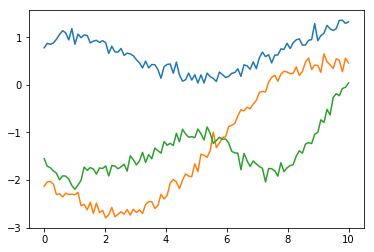

In [3]:
plt.plot(x, y.T);

In [4]:
with pm.Model() as model:
    sigma = pm.HalfNormal("sigma", sd=5)
    y_ = pm.MvNormal("y", mu=np.zeros(100), cov=K + sigma**2 * np.eye(100), observed=y)
    tr = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_log__]
100%|██████████| 1500/1500 [00:10<00:00, 138.28it/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


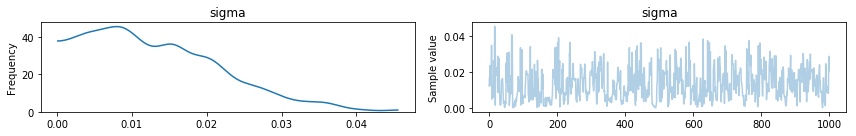

In [5]:
pm.traceplot(tr);

In [6]:
with model:
    ppc = pm.sample_ppc(tr, 200)

100%|██████████| 200/200 [00:00<00:00, 264.15it/s]


In [7]:
ppc["y"].shape

(200, 100)

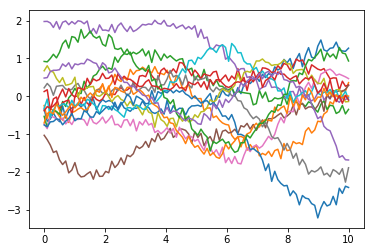

In [8]:
plt.plot(x, ppc["y"][0:15,:].T);

In [9]:
np.random.seed(500)

# draw sample from GP (f_true) as the true poisson mean (mu_true) as a function of x_true
l_true = 2.3
eta_true = 1.0
x = np.linspace(0, 15, 50)
cov = eta_true**2 * pm.gp.cov.ExpQuad(1, l_true)
f1_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
f2_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
f3_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
f4_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
mu1_true = np.exp(f1_true)
mu2_true = np.exp(f2_true)
mu3_true = np.exp(f3_true)
mu4_true = np.exp(f4_true)

y1 = np.random.poisson(mu1_true)
y2 = np.random.poisson(mu2_true)
y3 = np.random.poisson(mu3_true)
y4 = np.random.poisson(mu4_true)

Number of data points: 50


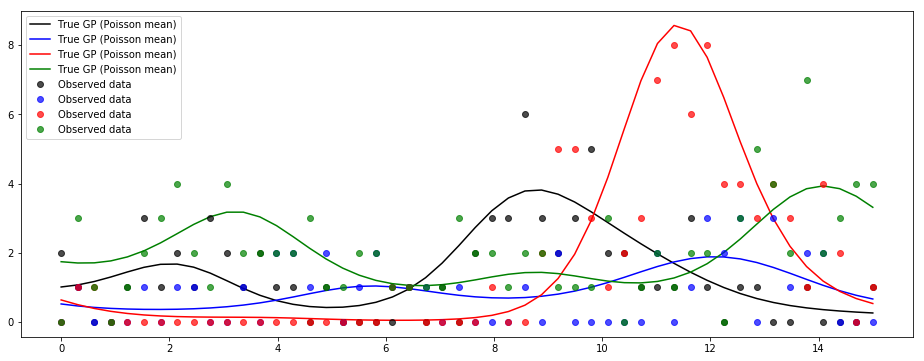

In [10]:
plt.figure(figsize=(16,6))
plt.plot(x, mu1_true, 'k', label="True GP (Poisson mean)")
plt.plot(x, mu2_true, 'blue', label="True GP (Poisson mean)")
plt.plot(x, mu3_true, 'r', label="True GP (Poisson mean)")
plt.plot(x, mu4_true, 'green', label="True GP (Poisson mean)")

plt.plot(x, y1, 'o', color="k", label="Observed data", alpha=0.7);
plt.plot(x, y2, 'o', color="blue", label="Observed data", alpha=0.7);
plt.plot(x, y3, 'o', color="r", label="Observed data", alpha=0.7);
plt.plot(x, y4, 'o', color="green", label="Observed data", alpha=0.7);
plt.legend();

n = len(x)
X = x[:,None]
Y = np.vstack([y1, y2]).T

print("Number of data points:", n)

# Full Latent GP

In [7]:
class Zero(pm.gp.mean.Mean):
    R"""
    Zero mean function for Gaussian process.

    """

    def __call__(self, X): 
        #return tt.alloc(0.0, X.shape[0], 1)
        return tt.alloc(0.0, 1, X.shape[0])


In [12]:
mu = Zero()(X).eval()
mu.shape

(1, 50)

In [13]:

with pm.Model() as model:
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sd=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Latent(cov_func=cov, mean_func=Zero())
    
    f = gp.prior("f", X=X, shape=(2, 50))
    
    y_ = pm.Poisson("y", mu=tt.exp(f), observed=Y.T)
    
    tr = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, eta_log__, l_log__]
100%|██████████| 1500/1500 [00:34<00:00, 43.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


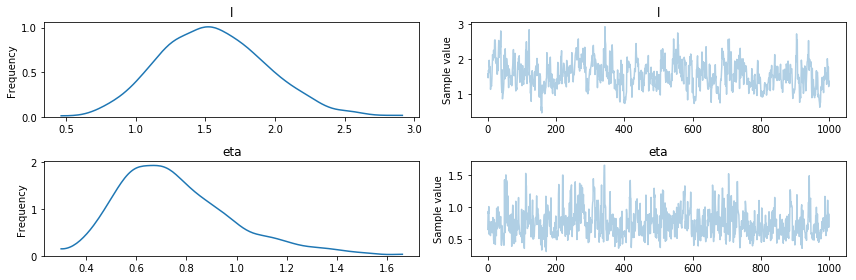

In [14]:
pm.traceplot(tr, varnames=["l", "eta"]);

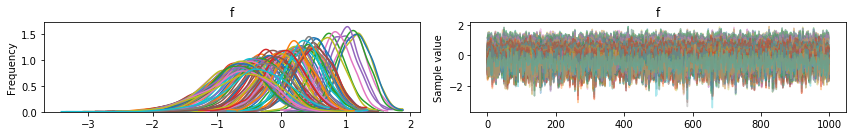

In [15]:
pm.traceplot(tr, varnames=["f"]);

In [16]:
tr["f"].shape

(1000, 2, 50)

# Conditional works with multiobs?

- Inference fine.
- I think maybe not.  Two obs of GPs, conditional below having shape problems.  Because of MvNormal.  Does that make sense?

In [18]:
gp.mean_func(Xnew).eval().shape

NameError: name 'Xnew' is not defined

In [20]:
Xnew = np.linspace(-1, 20, 200)[:,None]

with model:
    givens = gp._get_given_vals(None)
    mu, cov = gp._build_conditional(Xnew, *givens)
    chol = pm.gp.util.cholesky(pm.gp.util.stabilize(cov))
    shape = pm.gp.util.infer_shape(Xnew, (2, 200))
    fnew = pm.MvNormal("fnew", mu=mu, chol=chol, shape=shape) 

In [21]:
with model:
    preds = pm.sample_ppc(tr, vars=[fnew])

100%|██████████| 1000/1000 [00:08<00:00, 119.99it/s]


In [24]:
Xnew = np.linspace(-1, 20, 200)[:,None]

with model:
    fnew2 = gp.conditional("fnew2", Xnew=Xnew, shape=(2, 200))
    preds = pm.sample_ppc(tr, vars=[fnew2])

100%|██████████| 1000/1000 [00:07<00:00, 129.97it/s]


In [26]:
preds["fnew2"].shape

(1000, 2, 200)

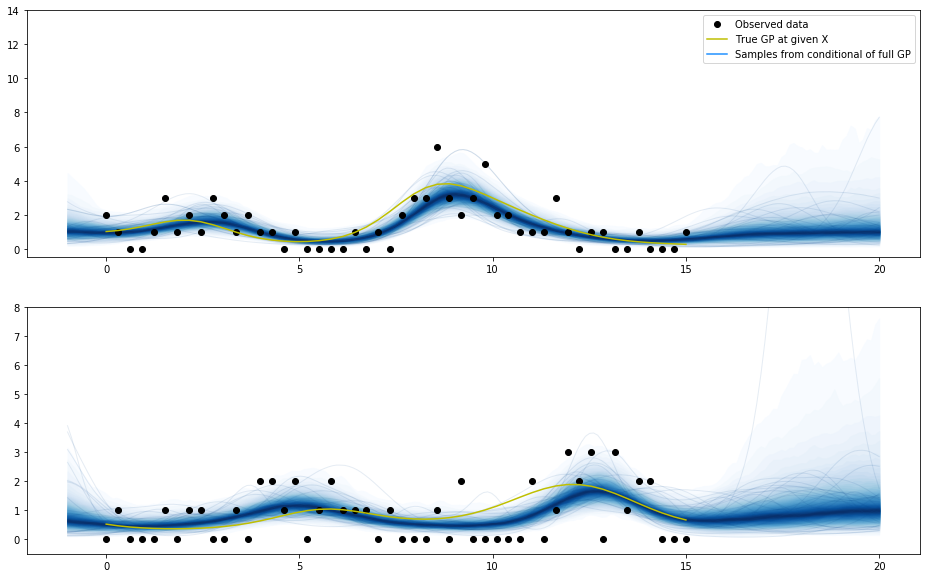

In [23]:
f, ax = plt.subplots(2, figsize=(16,10))
ax1, ax2 = ax

pm.gp.util.plot_gp_dist(ax1, np.exp(preds["fnew"][:,0,:]), Xnew.flatten(), palette="Blues")
ax1.plot(X.flatten(), y1, 'ok', label="Observed data");
ax1.plot(x, mu1_true, 'y', label="True GP at given X")
ax1.set_ylim([-0.5, 14])
ax1.plot(Xnew.flatten(), 1000+np.exp(preds["fnew"][:,0,:].T)[:,0], color="dodgerblue", label="Samples from conditional of full GP"); # plotted off screen for legend
ax1.legend();

pm.gp.util.plot_gp_dist(ax2, np.exp(preds["fnew"][:,1,:]), Xnew.flatten(), palette="Blues")
ax2.plot(X.flatten(), y2, 'ok', label="Observed data");
ax2.plot(x, mu2_true, 'y', label="True GP at given X")
ax2.set_ylim([-0.5, 8])
ax2.plot(Xnew.flatten(), 1000+np.exp(preds["fnew"][:,1,:].T)[:,0], color="dodgerblue", label="Samples from conditional of full GP"); # plotted off screen for legend

# Marginal

In [3]:
np.random.seed(500)

# draw sample from GP (f_true) as the true poisson mean (mu_true) as a function of x_true
l_true = 2.3
eta_true = 1.0
n = 100
x = np.linspace(0, 15, n)
cov = eta_true**2 * pm.gp.cov.ExpQuad(1, l_true)
f1_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
f2_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()

sigma2 = 0.25

y1 = f1_true + np.sqrt(sigma2) * np.random.randn(n)
y2 = f2_true + np.sqrt(sigma2) * np.random.randn(n)

Number of data points: 100
Y shape (100, 2) X shape (100, 1)


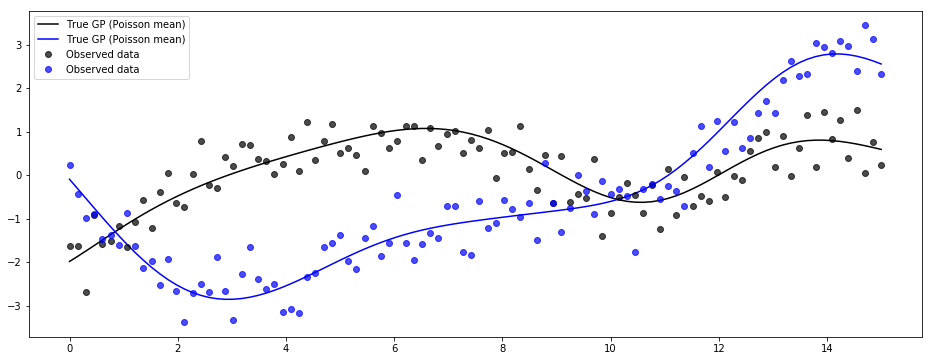

In [4]:
plt.figure(figsize=(16,6))
plt.plot(x, f1_true, 'k', label="True GP (Poisson mean)")
plt.plot(x, f2_true, 'blue', label="True GP (Poisson mean)")
plt.plot(x, y1, 'o', color="k", label="Observed data", alpha=0.7);
plt.plot(x, y2, 'o', color="blue", label="Observed data", alpha=0.7);
plt.legend();

n = len(x)
X = x[:,None]
Y = np.vstack([y1, y2]).T

print("Number of data points:", n)
print("Y shape", Y.shape, "X shape", X.shape)

# Full Marginal GP

- just transposing inputs to maringal_likelihood Normal makes things look fine...
- 

In [5]:
Y.shape

(100, 2)

In [8]:
with pm.Model() as model:
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sd=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Marginal(cov_func=cov, mean_func=Zero())
    
    sigma = pm.HalfNormal("sigma", sd=2)
    
    y_ = gp.marginal_likelihood("y", X=X, y=Y.T, noise=sigma2)
    
    tr = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_log__, eta_log__, l_log__]
100%|██████████| 1500/1500 [00:29<00:00, 51.38it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [30]:
# this works
pm.MvNormal.dist(mu=np.random.randn(10,2).T, cov=K).logp(tt.as_tensor_variable(np.random.randn(10,2).T)).eval()
# cuz each row is a sample, not a column as gp lib considers it. 

NameError: name 'K' is not defined

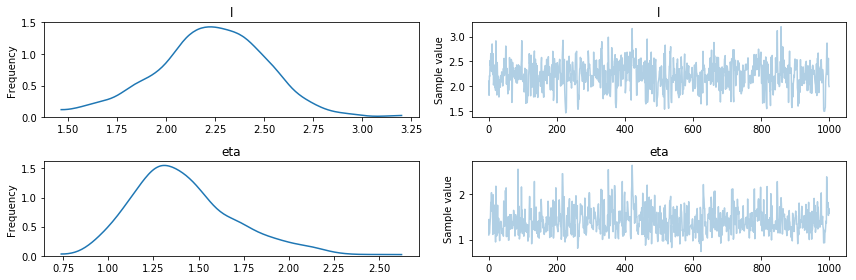

In [9]:
pm.traceplot(tr, varnames=["l", "eta"]);

In [10]:
Xnew = np.linspace(-1, 20, 200)[:,None]

with model:
    fnew = gp.conditional("fnew", Xnew=Xnew, shape=(2, 200))
    preds = pm.sample_ppc(tr, vars=[fnew])

100%|██████████| 1000/1000 [00:09<00:00, 102.99it/s]


In [11]:
preds["fnew"].shape

(1000, 2, 200)

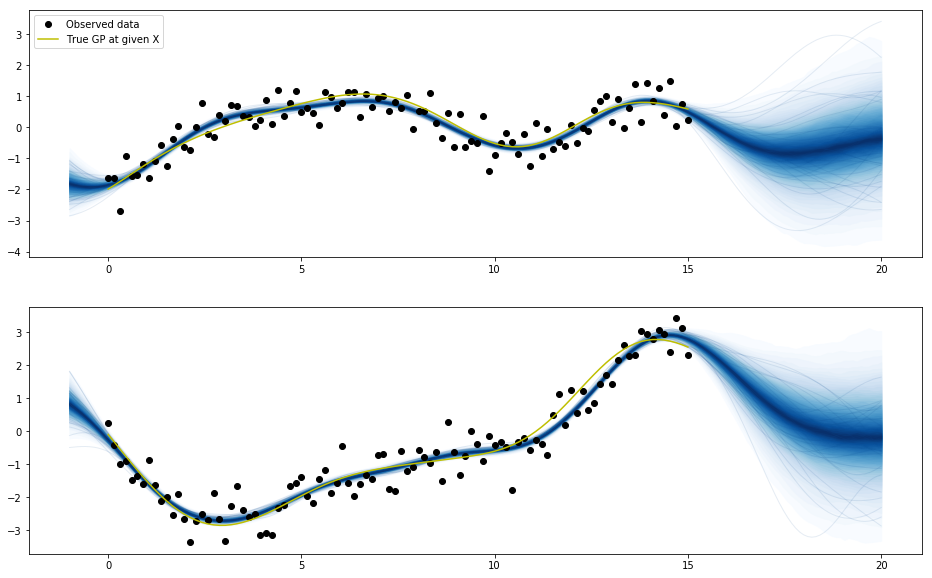

In [13]:
f, ax = plt.subplots(2, figsize=(16,10))
ax1, ax2 = ax

pm.gp.util.plot_gp_dist(ax1, preds["fnew"][:,0,:], Xnew.flatten(), palette="Blues")
ax1.plot(X.flatten(), y1, 'ok', label="Observed data");
ax1.plot(x, f1_true, 'y', label="True GP at given X")
ax1.legend();

pm.gp.util.plot_gp_dist(ax2, preds["fnew"][:,1,:], Xnew.flatten(), palette="Blues")
ax2.plot(X.flatten(), y2, 'ok', label="Observed data");
ax2.plot(x, f2_true, 'y', label="True GP at given X");

# Full Marginal GP (one output)

- just transposing inputs to maringal_likelihood Normal makes things look fine...
- 

In [14]:
Y.shape

(100, 2)

In [15]:
with pm.Model() as model:
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sd=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Marginal(cov_func=cov, mean_func=Zero())
    
    sigma = pm.HalfNormal("sigma", sd=2)
    
    y_ = gp.marginal_likelihood("y", X=X, y=Y[:,0], noise=sigma2)
    
    tr = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma_log__, eta_log__, l_log__]
100%|██████████| 1500/1500 [00:25<00:00, 58.57it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


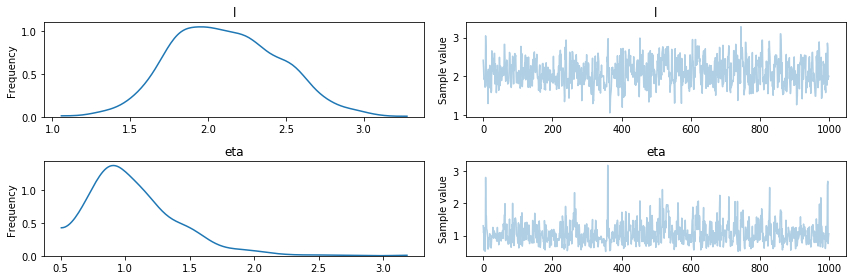

In [16]:
pm.traceplot(tr, varnames=["l", "eta"]);

In [18]:
Xnew = np.linspace(-1, 20, 200)[:,None]

with model:
    fnew = gp.conditional("fnew", Xnew=Xnew, shape=(1, 200))
    preds = pm.sample_ppc(tr, vars=[fnew])

100%|██████████| 1000/1000 [00:08<00:00, 118.18it/s]


In [19]:
preds["fnew"].shape

(1000, 1, 200)

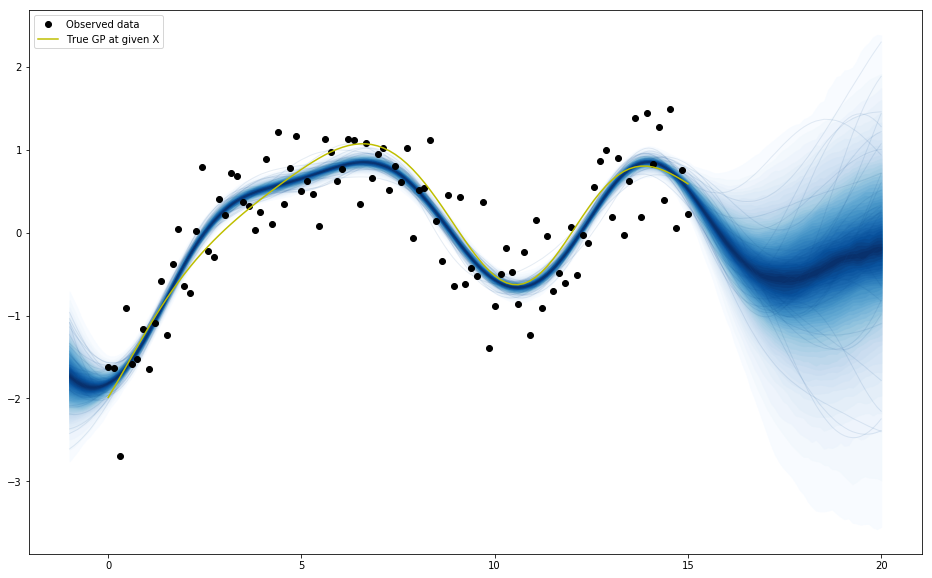

In [20]:
f, ax = plt.subplots(1, figsize=(16,10))

pm.gp.util.plot_gp_dist(ax, preds["fnew"][:,0,:], Xnew.flatten(), palette="Blues")
ax.plot(X.flatten(), y1, 'ok', label="Observed data");
ax.plot(x, f1_true, 'y', label="True GP at given X")
ax.legend();



# Full Latent GP (one output)

In [22]:
np.random.seed(500)

# draw sample from GP (f_true) as the true poisson mean (mu_true) as a function of x_true
l_true = 2.3
eta_true = 1.0
x = np.linspace(0, 15, 50)
cov = eta_true**2 * pm.gp.cov.ExpQuad(1, l_true)
f1_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
f2_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
f3_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
f4_true = np.random.multivariate_normal(np.zeros(len(x)), cov(x[:,None]).eval(), 1).flatten()
mu1_true = np.exp(f1_true)
mu2_true = np.exp(f2_true)
mu3_true = np.exp(f3_true)
mu4_true = np.exp(f4_true)

y1 = np.random.poisson(mu1_true)
y2 = np.random.poisson(mu2_true)
y3 = np.random.poisson(mu3_true)
y4 = np.random.poisson(mu4_true)

Number of data points: 50


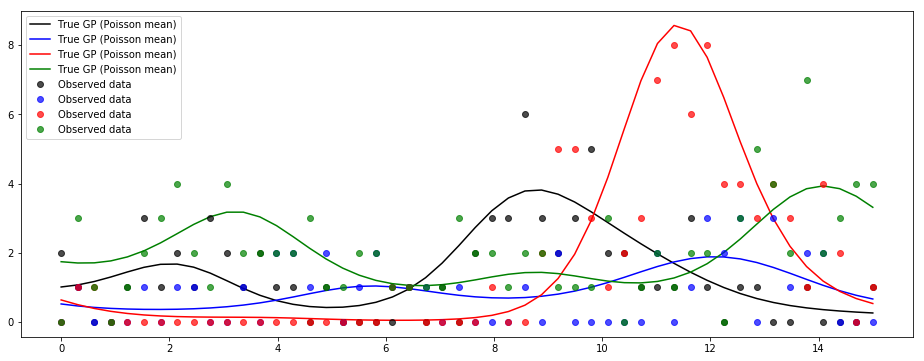

In [23]:
plt.figure(figsize=(16,6))
plt.plot(x, mu1_true, 'k', label="True GP (Poisson mean)")
plt.plot(x, mu2_true, 'blue', label="True GP (Poisson mean)")
plt.plot(x, mu3_true, 'r', label="True GP (Poisson mean)")
plt.plot(x, mu4_true, 'green', label="True GP (Poisson mean)")

plt.plot(x, y1, 'o', color="k", label="Observed data", alpha=0.7);
plt.plot(x, y2, 'o', color="blue", label="Observed data", alpha=0.7);
plt.plot(x, y3, 'o', color="r", label="Observed data", alpha=0.7);
plt.plot(x, y4, 'o', color="green", label="Observed data", alpha=0.7);
plt.legend();

n = len(x)
X = x[:,None]
Y = np.vstack([y1, y2]).T

print("Number of data points:", n)

In [24]:
Y.shape

(50, 2)

In [25]:

with pm.Model() as model:
    l = pm.Gamma("l", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sd=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, l)
    gp = pm.gp.Latent(cov_func=cov)
    
    f = gp.prior("f", X=X)
    
    y_ = pm.Poisson("y", mu=tt.exp(f), observed=Y[:,0])
    
    tr = pm.sample(1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [f_rotated_, eta_log__, l_log__]
100%|██████████| 1500/1500 [00:48<00:00, 31.07it/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


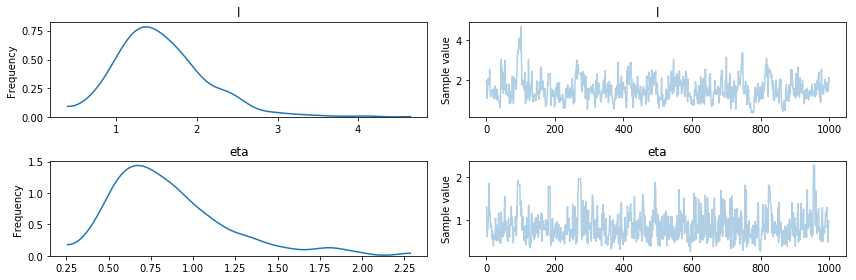

In [26]:
pm.traceplot(tr, varnames=["l", "eta"]);

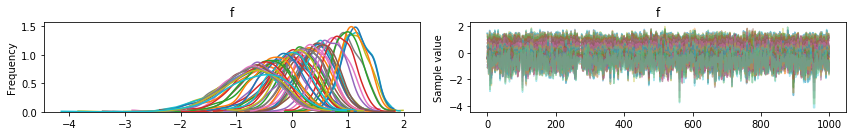

In [27]:
pm.traceplot(tr, varnames=["f"]);

In [28]:
tr["f"].shape

(1000, 1, 50)

# Conditional works with multiobs?

- Inference fine.
- I think maybe not.  Two obs of GPs, conditional below having shape problems.  Because of MvNormal.  Does that make sense?

In [29]:
gp.mean_func(Xnew).eval().shape

(1, 200)

In [30]:
Xnew = np.linspace(-1, 20, 200)[:,None]

with model:
    givens = gp._get_given_vals(None)
    mu, cov = gp._build_conditional(Xnew, *givens)
    chol = pm.gp.util.cholesky(pm.gp.util.stabilize(cov))
    shape = pm.gp.util.infer_shape(Xnew, (2, 200))
    fnew = pm.MvNormal("fnew", mu=mu, chol=chol, shape=shape) 

In [21]:
with model:
    preds = pm.sample_ppc(tr, vars=[fnew])

100%|██████████| 1000/1000 [00:08<00:00, 119.99it/s]


In [35]:
Xnew = np.linspace(-1, 20, 200)[:,None]

with model:
    fnew2 = gp.conditional("fnew3", Xnew=Xnew, shape=(1, 200))
    preds = pm.sample_ppc(tr, vars=[fnew2])

100%|██████████| 1000/1000 [00:07<00:00, 138.07it/s]


In [37]:
preds["fnew3"].shape

(1000, 1, 200)

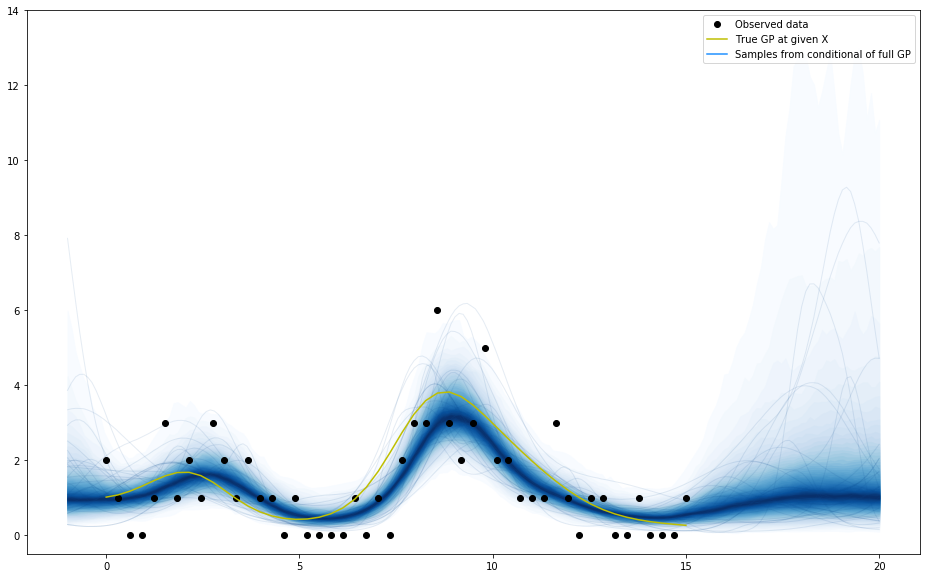

In [39]:
f, ax = plt.subplots(1, figsize=(16,10))

pm.gp.util.plot_gp_dist(ax, np.exp(preds["fnew3"][:,0,:]), Xnew.flatten(), palette="Blues")
ax.plot(X.flatten(), y1, 'ok', label="Observed data");
ax.plot(x, mu1_true, 'y', label="True GP at given X")
ax.set_ylim([-0.5, 8])
ax.plot(Xnew.flatten(), 1000+np.exp(preds["fnew3"][:,0,:].T)[:,0], color="dodgerblue", label="Samples from conditional of full GP"); # plotted off screen for legend
ax.legend();

